# Classify if image is a punch or not. 

## Import dependencies

In [1]:
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import re

### count nr of pictures in folder

In [2]:
count = 0
for files in os.listdir("./train"):
    count+= 1
print(count)    

1043


In [3]:
# Test to see if the images are correctly extracted by their names
txt = "no (1) no (100) yes (27) yes (100)"
sp = re.split(r"\s\(\d+\)",txt)
print(sp)

['no', ' no', ' yes', ' yes', '']


## Import data into array, resize, make it numpy, label yes = [1,0], no = [0,1] 

In [4]:
from random import shuffle

In [5]:
data = []
for files in os.listdir("./train"):
    image = cv2.resize(cv2.imread(os.path.join("./train/", files)),(224,224))
    new_img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    label = re.split(r"\s\(\d+\)",files)[0]
    if label == "yes":
        data.append([np.array(new_img), np.array([1,0])])
    elif label == "no":
        data.append([np.array(new_img), np.array([0,1])])   
shuffle(data)         
    

In [6]:
len(data)

1043

# CNN model

In [7]:
d_aug = Sequential([
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.3),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape = (100,100,3)),
])

In [8]:
model2 = Sequential()

model2.add(d_aug)
model2.add(Conv2D(16, (3, 3), 1, activation="relu", input_shape=(224, 224, 3)))
model2.add(MaxPooling2D())

model2.add(Conv2D(64, (3, 3), 1, activation="relu"))
model2.add(MaxPooling2D())

model2.add(Conv2D(16, (3, 3), 1, activation="relu"))
model2.add(MaxPooling2D())
model2.add(Dropout(0.15))

model2.add(Flatten())

model2.add(Dense(256, activation="relu"))
model2.add(Dense(2, activation="sigmoid")) #change to 1, change to sigmoid

#model2.summary()

## Optimizers, play around with learning_rate

In [9]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0010)
model2.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

## Cross Validation with KFold

In [10]:
from sklearn.model_selection import KFold

In [11]:
kf = KFold(n_splits = 5, shuffle=True)#, random_state=42)

In [12]:
X_data = np.array([i[0] for i in data]).reshape(-1, 224, 224, 3) 
y_data = np.array([i[1] for i in data])

X_data = X_data.astype("float32")/255

In [13]:
fold = 0

for train, test in kf.split(X_data): #put back "test" into the loop
    fold += 1
    print("training fold " + str(fold))
    X, x_validation = X_data[train], X_data[test]
    y, y_validation = y_data[train], y_data[test]

    model_name = "punch-model-aug-fold" + str(fold)
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir="logsowncnn-aug/{}".format(model_name))
    history2 = model2.fit(X, 
                          y, 
                          batch_size=32, 
                          epochs=5,
                          validation_data=(x_validation, y_validation), 
                          callbacks=[tb_callback]) #try validation_split = 0.1 instead of validation_data=(x_validation, y_validation)
    
model2.save("punch-model-sigmoid.h5", overwrite=True, include_optimizer=True)

training fold 1
Epoch 1/5
27/27 [==============================] - 38s 920ms/step - loss: 0.6849 - accuracy: 0.5312 - val_loss: 0.6161 - val_accuracy: 0.6603
Epoch 2/5
27/27 [==============================] - 23s 862ms/step - loss: 0.5506 - accuracy: 0.6990 - val_loss: 0.6752 - val_accuracy: 0.7464
Epoch 3/5
27/27 [==============================] - 23s 858ms/step - loss: 0.4954 - accuracy: 0.7530 - val_loss: 0.4087 - val_accuracy: 0.7751
Epoch 4/5
27/27 [==============================] - 23s 839ms/step - loss: 0.3943 - accuracy: 0.8129 - val_loss: 0.3268 - val_accuracy: 0.8469
Epoch 5/5
27/27 [==============================] - 41s 2s/step - loss: 0.3221 - accuracy: 0.8501 - val_loss: 0.2678 - val_accuracy: 0.8708
training fold 2
Epoch 1/5
27/27 [==============================] - 30s 849ms/step - loss: 0.3063 - accuracy: 0.8597 - val_loss: 0.2327 - val_accuracy: 0.8852
Epoch 2/5
27/27 [==============================] - 23s 843ms/step - loss: 0.2700 - accuracy: 0.8717 - val_loss: 0.2223 

In [14]:
test.shape

(208,)

In [15]:
print(X.shape)
print(y.shape)
print(x_validation.shape)
print(y_validation.shape)

(835, 224, 224, 3)
(835, 2)
(208, 224, 224, 3)
(208, 2)


# Plots of loss vs validation loss, accuracy vs val accuracy

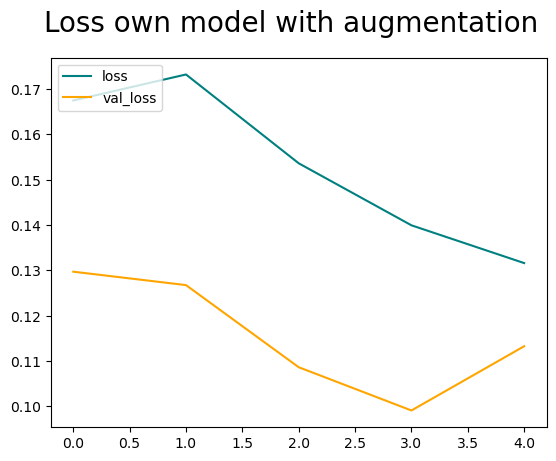

In [16]:
#Loss plot
fig = plt.figure()
plt.plot(history2.history["loss"], color = "teal", label = "loss")
plt.plot(history2.history["val_loss"], color = "orange", label = "val_loss")
fig.suptitle("Loss own model with augmentation", fontsize=20)
plt.legend(loc="upper left")
plt.show()

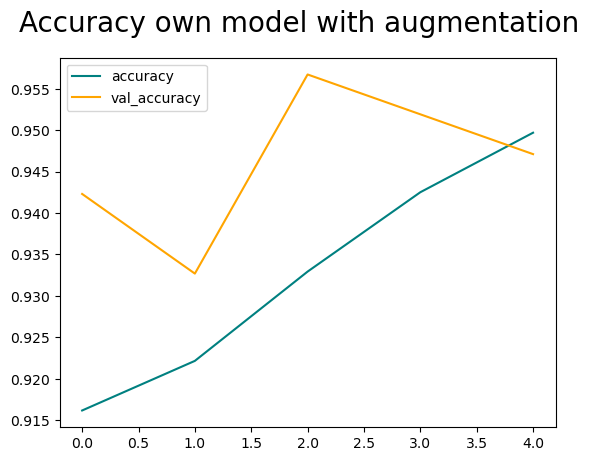

In [17]:
#Accuracy plot
fig = plt.figure()
plt.plot(history2.history["accuracy"], color = "teal", label = "accuracy")
plt.plot(history2.history["val_accuracy"], color = "orange", label = "val_accuracy")
fig.suptitle("Accuracy own model with augmentation", fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Show predictions

In [18]:
print("Evaluate on test data")
results = model2.evaluate(x_validation, y_validation, batch_size=32)
print("test loss, test acc:", results)


Evaluate on test data
7/7 [==============================] - 1s 136ms/step - loss: 0.1133 - accuracy: 0.9471
test loss, test acc: [0.11328058689832687, 0.9471153616905212]


In [19]:
#Generate predictions
print("Generate predictions for all samples")
predictions = model2.predict(x_validation) #uncomment this one and below one

print("predictions shape:", predictions.shape)

Generate predictions for all samples
7/7 [==============================] - 1s 134ms/step
predictions shape: (208, 2)


In [20]:
predictions.mean()

0.5019876

In [21]:
y_validation.shape

(208, 2)

# Test on new picture

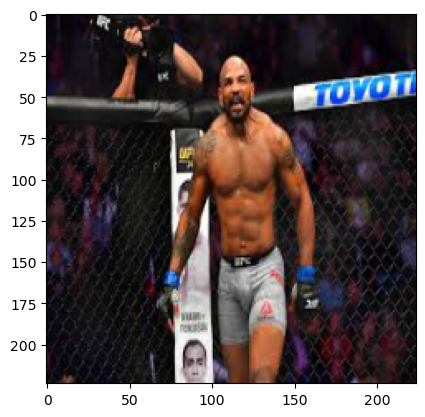

In [22]:
#Image that the model has not seen yet
img_array = cv2.imread("./test/no (4).jpg")
img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
new_array = cv2.resize(img_array, (224,224))
plt.imshow(new_array)
plt.show() 

## MAke prediction

In [23]:
y_test_pred = model2.predict(np.expand_dims(new_array/255, 0))

1/1 [==============================] - 0s 28ms/step


In [24]:
y_test_pred

array([[0.8184612 , 0.39793277]], dtype=float32)

# Rounded predictions

In [25]:
# Round the predictions to be able to show them in the confusion matrix
rounded_predictions = np.argmax(predictions, axis=-1)

### Rounded prdictions shows index of the highest number, so in this case rounded_predictions[0]=0,
### which means that index 0 in [1,0] had the highest probability and that would make the prediction a punch.

In [26]:
rounded_predictions

array([1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1], dtype=int64)

### Because of this transform, every 1 in rounded prediction should be a 0, and vice versa

In [27]:
rounded_predictions;

In [28]:
rounded_predictions=(~rounded_predictions.astype(bool)).astype(int)
rounded_predictions

array([0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0])

## Extract y_labels by taking the first element in each array, 1 = punch, 0 = no punch

In [29]:
#first_elements = [pair[0] for pair in pairs]
i = 0
y_val_extract = []

for pair in y_validation:
    y_val_extract.append(y_validation[i][0])
    i+=1
y_val_extract

[0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0]

# Confusion matrix

In [30]:
from sklearn.metrics import confusion_matrix
import itertools

In [31]:
cm = confusion_matrix(y_true=y_val_extract, y_pred=rounded_predictions)
cm

array([[117,   8],
       [  3,  80]], dtype=int64)

In [32]:
#Code copied from sklearn
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[117   8]
 [  3  80]]


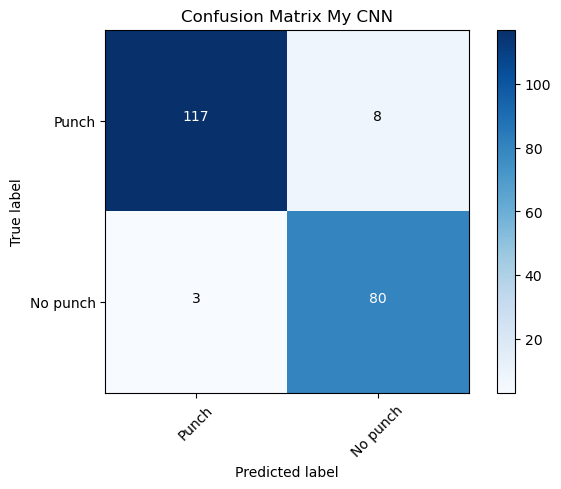

In [33]:
cm_plot_labels = ["Punch", "No punch"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix My CNN")

In [34]:
tn, fp, fn, tp = confusion_matrix(y_true=y_val_extract, y_pred=rounded_predictions).ravel()
(tn, fp, fn, tp)

(117, 8, 3, 80)

# Test predicting

In [35]:
pred_data = []
for files in os.listdir("./test"):
    #Resize all pictures to the same size
    p_image = cv2.resize(cv2.imread(os.path.join("./test/", files)),(224,224)) 
    p_image = cv2.cvtColor(p_image, cv2.COLOR_RGB2BGR)
    #Split labels on yes or no
    label = re.split(r"\s\(\d+\)",files)[0]
    if label == "yes":
        pred_data.append([np.array(p_image), np.array([1,0])])
    elif label == "no":
        pred_data.append([np.array(p_image), np.array([0,1])]) 

In [36]:
np.asanyarray(pred_data).shape

c:\Users\jonat\Anaconda3\envs\mmascore\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(10, 2)

In [37]:
X_pred = np.array([i[0] for i in pred_data]).reshape(-1, 224, 224, 3) 
y_pred = np.array([i[1] for i in pred_data])

X_pred = X_pred.astype("float32")/255

In [38]:
from tensorflow.keras.models import load_model

In [39]:
own_model = load_model("punch-model-sigmoid.h5")

In [40]:
own_model.predict(X_pred) #np.expand_dims(X_pred/255, 0)

1/1 [==============================] - 0s 136ms/step


array([[2.2968184e-04, 9.9977177e-01],
       [9.6047562e-01, 4.0177103e-02],
       [4.4470042e-01, 5.0828117e-01],
       [8.1846100e-01, 3.9793268e-01],
       [7.5462526e-01, 3.0067188e-01],
       [9.7739315e-01, 2.6816137e-02],
       [9.8147833e-01, 2.4571909e-02],
       [9.9014199e-01, 8.2244994e-03],
       [9.0146894e-03, 9.9344379e-01],
       [8.0531043e-01, 1.7479643e-01]], dtype=float32)

In [41]:
for i in y_pred:
    print(i)

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]


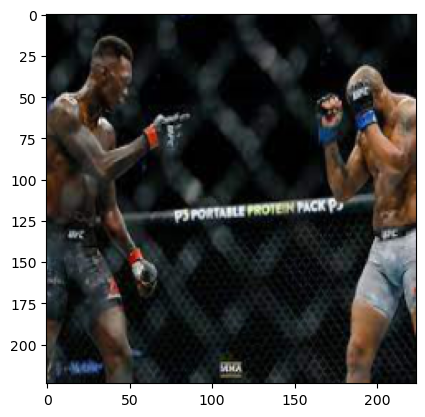

In [42]:
plt.imshow(X_pred[0])

In [43]:
res = own_model.evaluate(X_pred, y_pred, batch_size=2)
print("test loss, test acc:", res)

5/5 [==============================] - 0s 13ms/step - loss: 1.1601 - accuracy: 0.6000
test loss, test acc: [1.1600934267044067, 0.6000000238418579]
